# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Sebastian | Vanegas Perez | Sebastian Vanegas Perez, 06/11/2024 | 7.5 | 25 |
| Member 2: | Subhreet | Jhinger | Subhreet Jhinger,06/11/2024 | 7.5 | 25 |
| Member 3: | Abdullah | Ajlan | Abdullah Ajlan, 06/11/2024 | 7.5 | 25 |
| Member 4: | Lisa | Brantuo | Lisa Brantuo, 06/11/2024 | 7.5 | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

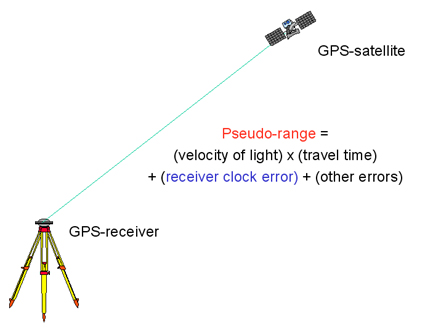

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install openpyxl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_3/

/content/drive/MyDrive/engg680_2024_fall/Lab_3


In [4]:
!ls

Assignment3.ipynb  pseudoranges_1.xlsx	satellite_position_1.xlsx


Step 0.2: Read and parse data files

In [5]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_3/pseudoranges_1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_3/satellite_position_1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size




Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [6]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [7]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [8]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [9]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges

def cost_function(r_pos, cdT, s_pos, pseudorange):
    predicted_rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = predicted_rho - cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [10]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)

def gradient(r_pos, cdT, s_pos, pseudorange):
    predicted_rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = predicted_rho - cdT
    residuals = pseudorange - predicted_pseudorange
    grad = np.zeros(4)

    for i in range(3):
        grad[i] = -2 * np.sum(residuals * (r_pos[i] - s_pos[:, i]) / predicted_rho)

    grad[3] = 2 * np.sum(residuals)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [11]:
# Gradient descent algorithm for non-linear least squares estimation

def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros
    X = np.array([0, 0, 0, 0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates using the gradient and learning rate
        X_new = X - learning_rate * grad

        # Compute the new cost
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Break the loop if convergence is achieved
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [12]:
optimized_params = gradient_descent(pseudorange, sat_pos)
final_position_errors = optimized_params[:3] - GroundTruth

# Print the mentioned metrics
print("Optimized parameters:", optimized_params)
print("Final position errors of receiver:", final_position_errors)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged!
Optimized parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46523154e+00]
Final position errors of receiver: [-3.06414102 -2.35598329  3.80119585]
Number of steps taken for convergence: 2871
Final cost value: 6.197094461711757
Final gradient values: [ 0.00049101  0.00273591 -0.00840859  0.00476703]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

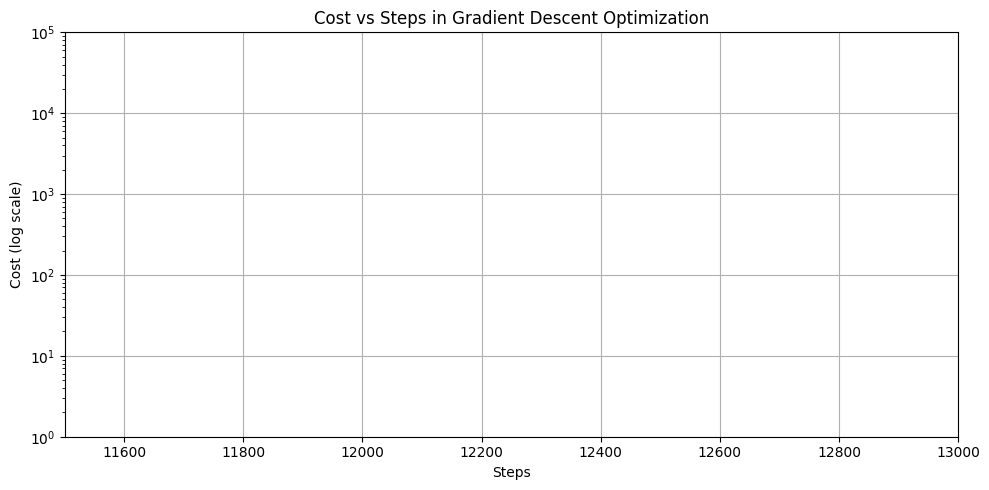


At the beginning, the cost function rapidly decreases, suggesting a sharp decrease as the algorithm advances significantly toward convergence.
The cost decrease slows down as the optimization process goes on, indicating that the algorithm is getting close to the minimum. This plateau
effect in subsequent phases suggests convergence or getting close to the minimum when step-by-step cost changes become negligible.



In [13]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.semilogy(range(len(arr_cost)), arr_cost, label="Cost")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (log scale)")
ax.set_title("Cost vs Steps in Gradient Descent Optimization")

ax.set_xlim([11500, 13000])
ax.set_ylim([1, 100000])

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("""
At the beginning, the cost function rapidly decreases, suggesting a sharp decrease as the algorithm advances significantly toward convergence.
The cost decrease slows down as the optimization process goes on, indicating that the algorithm is getting close to the minimum. This plateau
effect in subsequent phases suggests convergence or getting close to the minimum when step-by-step cost changes become negligible.
""")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

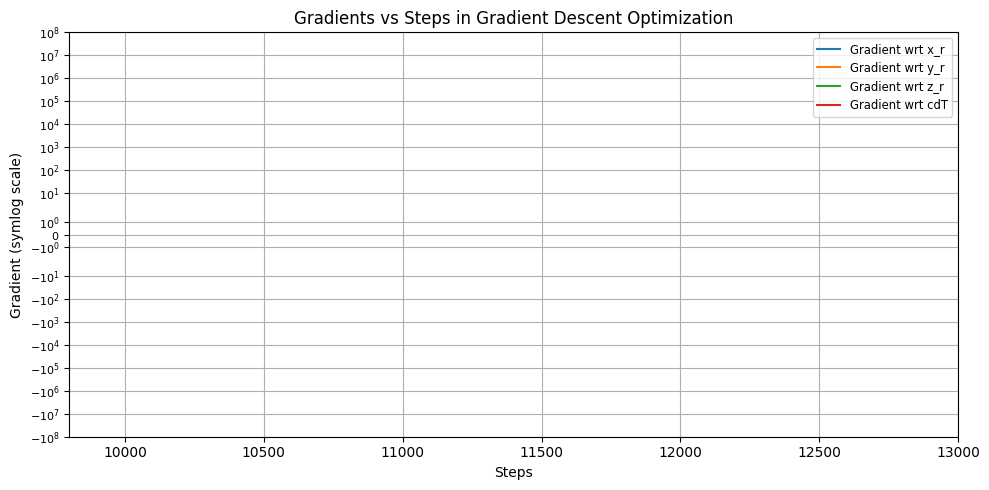


We can see from the figure that the gradients begin with comparatively high values and progressively get smaller as the optimization goes on.
Given that the model updates are decreasing with time, this decrease in gradient magnitude suggests convergence. Gradients that are close to
zero indicate that the solution is nearing its optimal state and that there is little need for more updates. As gradient descent methods
converge to a solution, this pattern is common.



In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

arr_grad = np.array(arr_grad)

ax.plot(range(len(arr_grad)), arr_grad[:, 0], label="Gradient wrt x_r")
ax.plot(range(len(arr_grad)), arr_grad[:, 1], label="Gradient wrt y_r")
ax.plot(range(len(arr_grad)), arr_grad[:, 2], label="Gradient wrt z_r")
ax.plot(range(len(arr_grad)), arr_grad[:, 3], label="Gradient wrt cdT")

ax.set_yscale('symlog')

ax.set_xlim([9800, 13000])
ax.set_ylim([-1e8, 1e8])

ax.set_xlabel("Steps")
ax.set_ylabel("Gradient (symlog scale)")
ax.set_title("Gradients vs Steps in Gradient Descent Optimization")
ax.legend(loc="upper right", fontsize="small")

ax.tick_params(axis='y', labelsize=8)

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern

print("""
We can see from the figure that the gradients begin with comparatively high values and progressively get smaller as the optimization goes on.
Given that the model updates are decreasing with time, this decrease in gradient magnitude suggests convergence. Gradients that are close to
zero indicate that the solution is nearing its optimal state and that there is little need for more updates. As gradient descent methods
converge to a solution, this pattern is common.
""")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

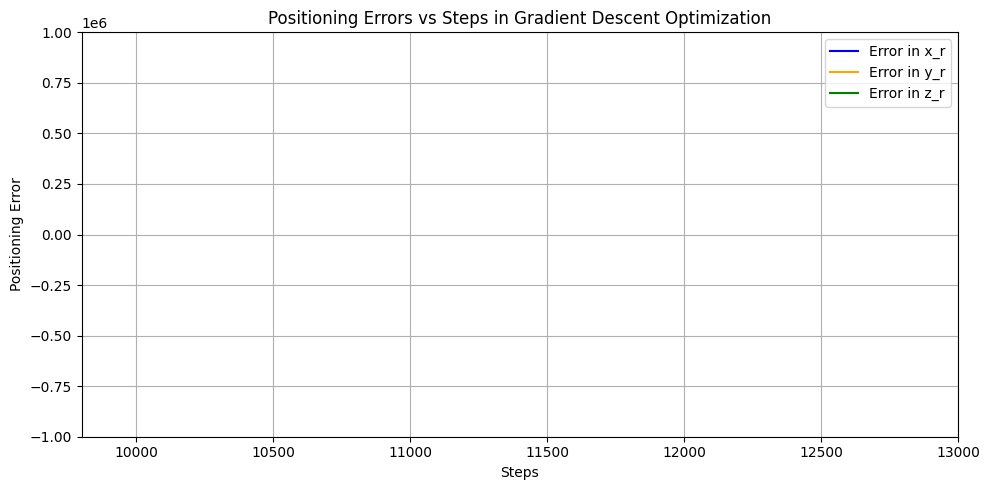


Normally, we would anticipate the following on the plot of positioning errors vs steps:

As the algorithm iterates through the stages, the initial placement error is significant but progressively diminishes.
- As the gradient descent approaches the optimal point, the errors in each component (x, y, and z) converge toward zero
  or a minimal value.
- As the algorithm develops, there may be some fluctuations at first, but they should subside as the location estimations
  approach the ground truth.

Depending on the satellite geometry and initial estimation errors, the rate of convergence for each coordinate component
may differ, and certain axes may take longer to converge.



In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.plot(range(len(arr_err)), [err[0] for err in arr_err], label="Error in x_r", color="blue")
ax.plot(range(len(arr_err)), [err[1] for err in arr_err], label="Error in y_r", color="orange")
ax.plot(range(len(arr_err)), [err[2] for err in arr_err], label="Error in z_r", color="green")

ax.set_xlim([9800, 13000])
ax.set_ylim([-1e6, 1e6])

ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error")
ax.set_title("Positioning Errors vs Steps in Gradient Descent Optimization")
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("""
Normally, we would anticipate the following on the plot of positioning errors vs steps:

As the algorithm iterates through the stages, the initial placement error is significant but progressively diminishes.
- As the gradient descent approaches the optimal point, the errors in each component (x, y, and z) converge toward zero
  or a minimal value.
- As the algorithm develops, there may be some fluctuations at first, but they should subside as the location estimations
  approach the ground truth.

Depending on the satellite geometry and initial estimation errors, the rate of convergence for each coordinate component
may differ, and certain axes may take longer to converge.
""")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [16]:
# Set learning rate to 0.01
learning_rate = 0.01

# Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=100000, tolerance=1e-6)

# Print metrics
print("Results with learning rate = 0.01")
print("Optimized parameters:", optimized_params_2)
print("Final position errors of receiver:", optimized_params_2[:3] - GroundTruth)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1] if arr_cost else None)
print("Final gradient values:", arr_grad[-1] if arr_grad else None)

Converged!
Results with learning rate = 0.01
Optimized parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46523154e+00]
Final position errors of receiver: [-3.06414102 -2.35598329  3.80119585]
Number of steps taken for convergence: 2871
Final cost value: 6.197094461711757
Final gradient values: [ 0.00049101  0.00273591 -0.00840859  0.00476703]


In [17]:
# Set learning rate to 0.001
learning_rate = 0.001

# Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=200000, tolerance=1e-6)

# Print metrics
print("\nResults with learning rate = 0.001")
print("Optimized parameters:", optimized_params_3)
print("Final position errors of receiver:", optimized_params_3[:3] - GroundTruth)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1] if arr_cost else None)
print("Final gradient values:", arr_grad[-1] if arr_grad else None)

Converged!

Results with learning rate = 0.001
Optimized parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.45048680e+00]
Final position errors of receiver: [-3.0626223  -2.34752101  3.77518774]
Number of steps taken for convergence: 27145
Final cost value: 6.197742857487326
Final gradient values: [ 0.00154868  0.00862914 -0.02652096  0.01503548]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

The plot of positioning errors vs steps shows that the initial placement error decreases as the algorithm iterates through stages. As the gradient descent approaches the optimal point, the errors in each component (x, y, and z) converge toward zero or a minimal value.

Initially, there may be fluctuations but they should subside as location estimations approach the ground truth. The rate of convergence for each coordinate component may differ depending on satellite geometry and initial estimation errors. With a comparable end cost value of around 6.198, the convergence needed a significantly higher number of steps (27,145). The method took smaller steps due to the decreased learning rate, which required more iterations to converge.

In conclusion, a slower learning rate (0.001) leads to a more gradual decline towards the minimum, providing more stability but taking longer to converge. A higher learning rate (0.01) accelerates convergence but may cause overshooting.
```
```
Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)

Parameter optimization involves two techniques: least squares estimation (LSE) and gradient descent. LSE minimizes squared residuals in a closed-form solution to find the best-fit parameters, which may be challenging for big nonlinear problems. It works well for linear issues when a direct solution is practical and computationally efficient.

Gradient descent, an iterative optimization process, optimizes the cost function by gradually changing parameters in the direction of the negative gradient. It is useful for complicated or nonlinear functions where a closed-form solution is impractical. However, gradient descent may take many iterations to converge and requires careful hyperparameter adjustment.

The study found that Gradient Descent's convergence time varies with the learning rate, taking thousands of iterations. This iterative method outperforms LSE's one-step solution technique, as the final cost values produced are comparable at different learning rates. However, the method's efficiency relies heavily on hyperparameter tweaking, as the time required to achieve these values varies significantly depending on the learning rate.

In Summary, gradient Descent manages complex, nonlinear systems with repetitive computation and hyperparameter sensitivity, while LSE offers minimal error for simpler situations.
```
```
ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [19]:
!pip install ucimlrepo

In [20]:
from ucimlrepo import fetch_ucirepo

phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print(phishing_websites.metadata)
print(phishing_websites.variables)

{'uci_id': 327, 'name': 'Phishing Websites', 'repository_url': 'https://archive.ics.uci.edu/dataset/327/phishing+websites', 'data_url': 'https://archive.ics.uci.edu/static/public/327/data.csv', 'abstract': 'This dataset collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 11055, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['result'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Tue Mar 05 2024', 'dataset_doi': '10.24432/C51W2X', 'creators': ['Rami Mohammad', 'Lee McCluskey'], 'intro_paper': {'ID': 396, 'type': 'NATIVE', 'title': 'An assessment of features related to phishing websites using an automated technique', 'authors': 'R. Mohammad, F. Thabtah, L. Mccluskey', 'venue': 'International Conference for Internet Tec

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

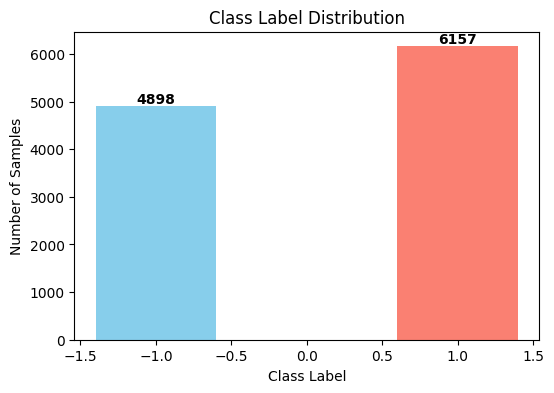

In [21]:
# TO DO: Check the class distribution of y (2 mark)

unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Label Distribution")

# Display exact values for each bin in the histogram
for label, count in class_counts.items():
    plt.text(label, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [22]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(X, y, test_size=0.03, random_state=42, stratify=y)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (10723, 30)
Size of y_small: (10723, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [23]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=2000)

log_reg_model.fit(X, y)
print("Model trained on full dataset (X and y)")

log_reg_model.fit(X.iloc[:, :2], y)
print("Model trained on first two columns of X and y")

log_reg_model.fit(X_small, y_small)
print("Model trained on smaller dataset (X_small and y_small)")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model trained on full dataset (X and y)
Model trained on first two columns of X and y
Model trained on smaller dataset (X_small and y_small)


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [27]:
from sklearn.metrics import accuracy_score, log_loss

def evaluate_model(X_data, y_data, description):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)

    data_size = X_data.shape[0]
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_log_loss = log_loss(y_test, y_test_prob)

    print(f"\nMetrics for {description}:")
    print(f"Data size: {data_size}")
    print(f"Number of training samples: {train_size}")
    print(f"Number of testing samples: {test_size}")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Testing accuracy: {test_accuracy:.4f}")
    print(f"Log loss: {test_log_loss:.4f}")

evaluate_model(X, y, "Full dataset (X and y)")

evaluate_model(X.iloc[:, :2], y, "First two columns of X and y")

evaluate_model(X_small, y_small, "Smaller dataset (X_small and y_small)")


Metrics for Full dataset (X and y):
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9311
Testing accuracy: 0.9219
Log loss: 0.1879

Metrics for First two columns of X and y:
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.5540
Testing accuracy: 0.5773
Log loss: 0.6774

Metrics for Smaller dataset (X_small and y_small):
Data size: 10723
Number of training samples: 7506
Number of testing samples: 3217
Training accuracy: 0.9294
Testing accuracy: 0.9248
Log loss: 0.1886


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [28]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

def get_metrics(X_data, y_data, description):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)

    data_size = X_data.shape[0]
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_log_loss = log_loss(y_test, y_test_prob)

    return {
        "Description": description,
        "Data size": data_size,
        "Training samples": train_size,
        "Testing samples": test_size,
        "Training accuracy": train_accuracy,
        "Testing accuracy": test_accuracy,
        "Log loss": test_log_loss
    }

metrics_full_dataset = get_metrics(X, y, "Full dataset (X and y)")
metrics_first_two_columns = get_metrics(X.iloc[:, :2], y, "First two columns of X and y")
metrics_small_dataset = get_metrics(X_small, y_small, "Smaller dataset (X_small and y_small)")

results = pd.DataFrame([
    metrics_full_dataset,
    metrics_first_two_columns,
    metrics_small_dataset
])

print(results)

                             Description  Data size  Training samples  \
0                 Full dataset (X and y)      11055              7738   
1           First two columns of X and y      11055              7738   
2  Smaller dataset (X_small and y_small)      10723              7506   

   Testing samples  Training accuracy  Testing accuracy  Log loss  
0             3317           0.932282          0.922822  0.190326  
1             3317           0.562807          0.556828  0.683573  
2             3217           0.929257          0.924775  0.181991  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [29]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print("Predicted output dimensions:", y_test_pred.shape)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", class_report)

Predicted output dimensions: (3317,)
Confusion Matrix:
 [[1341  157]
 [  99 1720]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



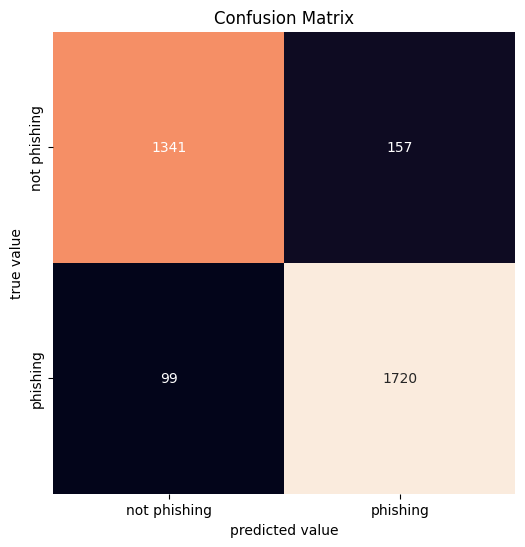

In [36]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_test_pred)

# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

# TO DO: Print classification report (2 marks)
plt.title('Confusion Matrix')
plt.show()

### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)

The classification report and the confusion matrix demonstrate that the dataset is reasonably balanced. The test set consists 1,819 samples for the "phishing" class and 1,498 samples for the "not phishing" class. Since the Class is fairly balanced, it shouldn't have a major impact on model performance.
```
```
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)

- For the full data set- The values for training accuracy and testing accuracy which are 93.11% and 92.19% respectively are comparable, making it a well-fitted model.

- For the First two columns of X and Y- The values for training accuracy and testing accuracy are 55.40% and 57.73% respectively, which are quite low, making it an underfitting model. This also implies that extracting information based on the first two columns of X and Y is insufficient for accurately predicting the pattern of the model.

- For Smaller dataset (X_small and y_small)- The values for training accuracy and testing accuracy which are 92.94% and 92.48% respectively are again very similar, depicting it to be a well-fitted model without certain overfitting or underfitting also like the full dataset case.
```
```
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)

While comparing the accuracy values for the different feature set, it shows:

- For the full data set- The training accuracy is 93.11% and the testing accuracy is 92.11%, resulting in high accuracy.

- For the First two columns of X and y- The training accuracy is 55.40% and the testing accuracy is 57.73%, which illustrates that when we reduce the dataset features, it also reduces the accuracy significantly.

- For Smaller datasets (X_small and Y_small)- The training accuracy is 92.94% and the testing accuracy is 92.48%, identical to the full set case.

Thus, it suggests that using the full data set i.e the larger feature set yields high accuracy even if the smaller sample size( X_small and Y_small). However, reducing the feature set has a direct impact, resulting in low accuracy.
```
```
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)

A Type I error, also known as a False Positive would indicate that it should be expected the website is phishing when actually the website is not phishing. A Type II error, or False Negative is when a website is projected to be not phishing when it actually is phishing. A false negative is worse in this case since it indicates that a phishing website is considered secure, which could expose visitors to fraud or data theft. To protect users, it is essential to make sure that phishing sites are accurately detected.
```
```
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)

Optimizing recall for the phishing class is more crucial because false negatives (missing phishing sites) are more damaging.

In order to maximize recall, modify the decision threshold to increase the likelihood that the model would identify instances as phishing; decreasing the threshold may improve recall but reduce precision. Additionally, use sampling techniques to correct for any minor imbalance or class weighting to give the phishing class a higher priority.
```
```
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)

The model is well-calibrated, producing probabilities that are close to the actual class labels, as indicated by the low Log Loss value of 0.1879 for the Full dataset (X and y).

With only two features, the model is ill-calibrated, resulting in a high degree of uncertainty and low confidence in its predictions for first two columns of X and y: Log Loss = 0.6774).

For Log Loss = 0.1886 for the smaller dataset (X_small and y_small), this log loss is extremely near to the whole dataset's log loss, suggesting comparable model calibration and performance. The second case's feature set reduction is the cause of the Log Loss differences. Predictions are poor when only the first two columns of features are used because insufficient information is captured. On the other hand, a larger feature set results in low Log Loss and strong model performance even with fewer data.


ANSWER HERE

---
---